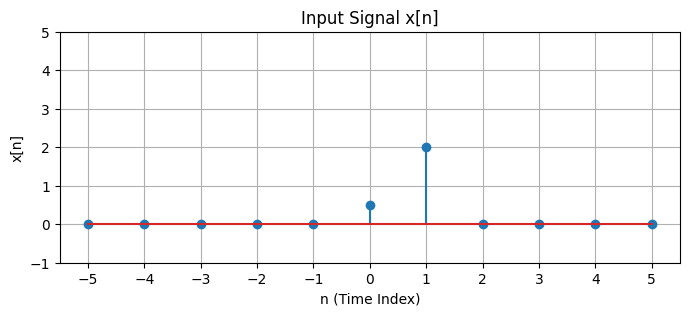

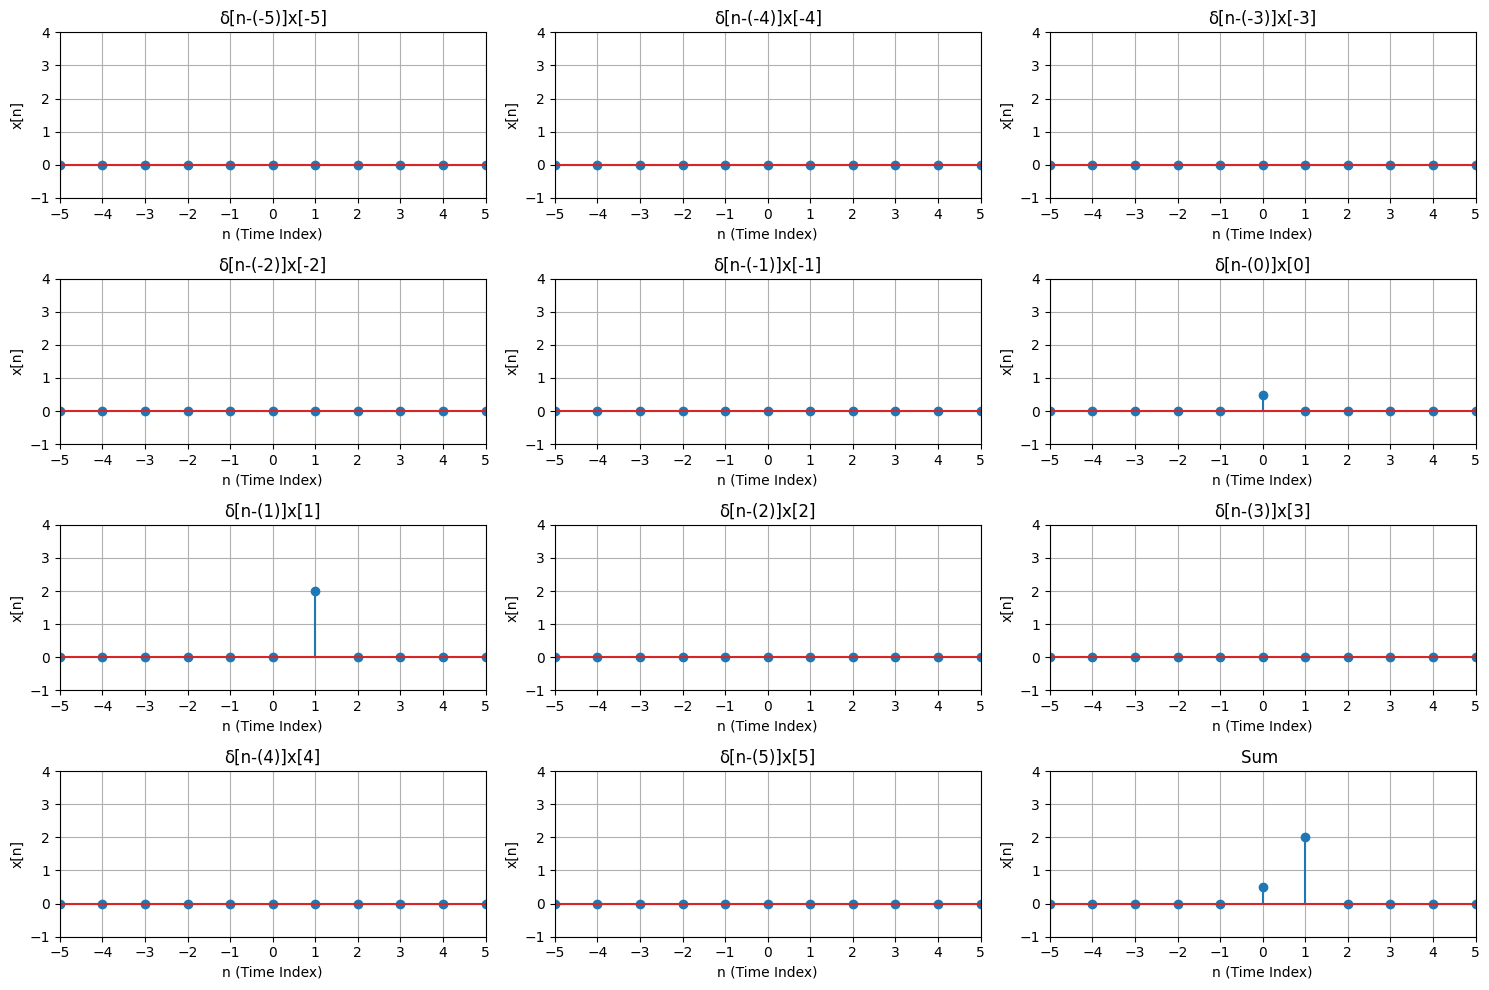

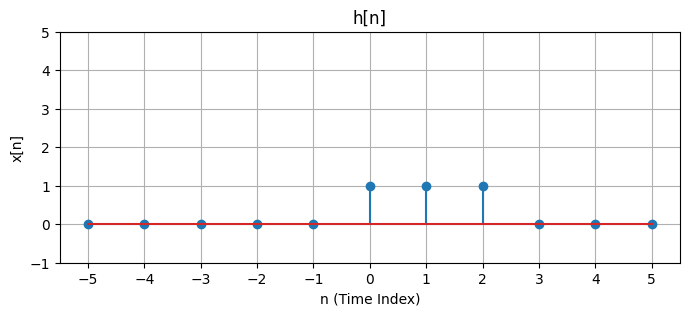

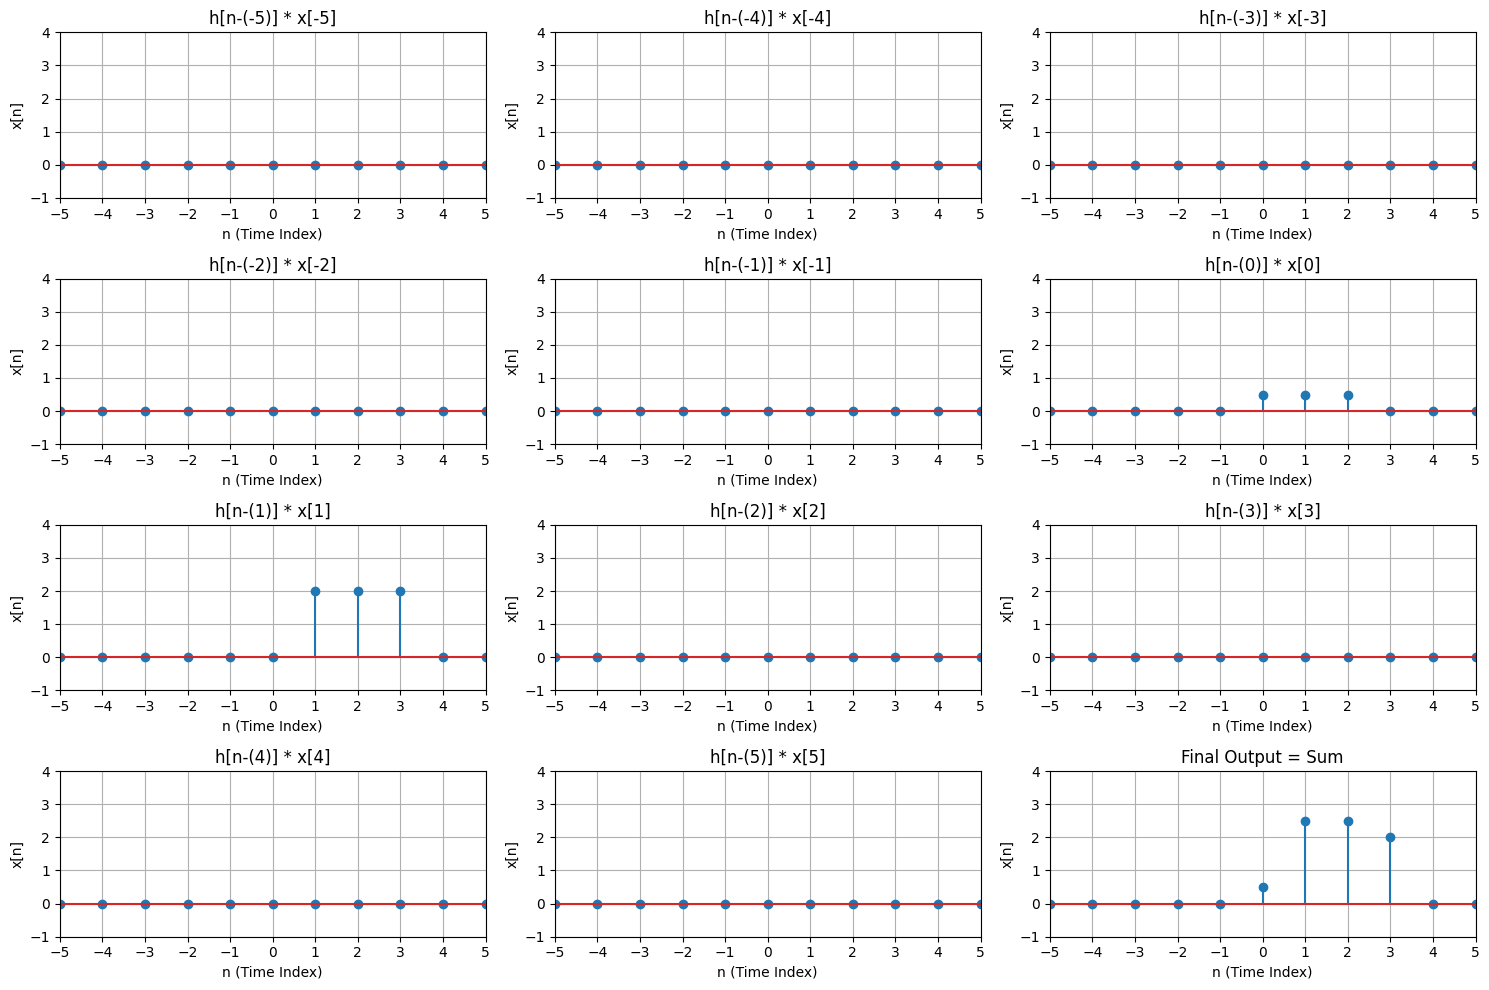

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
class DiscreteSignal:
    def __init__(self, INF,initial_values=None):
        self.INF=INF
        self.values=np.zeros(2*INF+1)
            

    def set_value_at_time(self,time,value):
        if -self.INF<=time<=self.INF:
            self.values[time+self.INF]=value
        else:
            raise ValueError("Time must be in the INF -INF to INF")

    def shift_signal(self,shift):
        shifted_signal=DiscreteSignal(self.INF)
        shifted_signal.values=np.roll(self.values,shift)
        return shifted_signal
 
    def add(self,other):
         if len(self.values)!=len(other.values):
             raise ValueError("Both signals must have the same length to add ")
         result=DiscreteSignal(self.INF)
         result.values=self.values+other.values
         return result
    
    def multiply(self, other):
        if len(self.values)!=len(other.values):
             raise ValueError("Both signals must have the same length to multiply ")
        result=DiscreteSignal(self.INF)
        result.values=self.values*other.values
        return result
    
    def multiply_const_factor(self,factor):
        result=DiscreteSignal(self.INF)
        result.values=self.values*factor
        return result

    def plot(self, title=None, y_range=(-1, 4), figsize=(8, 3), x_label='n (Time Index)', y_label='x[n]', saveTo=None):
        plt.figure(figsize=figsize)
        plt.xticks(np.arange(-self.INF, self.INF + 1, 1))
        y_range = (y_range[0], max(np.max(self.values), y_range[1]) + 1)
        plt.ylim(*y_range)
        plt.stem(np.arange(-self.INF, self.INF + 1, 1), self.values)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.grid(True)
        if saveTo is not None:
            plt.savefig(saveTo)
        plt.show()

    def get_values(self,n):
        return self.values[n]







##LTI Discrete class Implementation ##

class LTIDiscrete:
    def __init__(self, impulse_response):
        self.impulse_response = impulse_response


    def linear_combination_of_impulses(self,input_signal):
        impulses =[]
        coefficients=[]

        for i in range(-input_signal.INF,input_signal.INF+1):
            impulse_value=input_signal.values[i+input_signal.INF]
            if impulse_value!= 0:
                unit_impulse=DiscreteSignal(input_signal.INF)
                unit_impulse.set_value_at_time(i, 1)
                impulses.append(unit_impulse)
                coefficients.append(impulse_value)
            else:
                unit_impulse=DiscreteSignal(input_signal.INF)
                unit_impulse.set_value_at_time(i, 0)
                impulses.append(unit_impulse)
                coefficients.append(impulse_value)
                
        return impulses, coefficients
    

    def output(self, input_signal):
        impulses, coefficients = self.linear_combination_of_impulses(input_signal)
        output_signal = DiscreteSignal(input_signal.INF)
        for impulse, coefficient in zip(impulses, coefficients):
            shifted_response=self.impulse_response.shift_signal(np.argmax(impulse.values)-input_signal.INF)
            output_signal = output_signal.add(shifted_response.multiply_const_factor(coefficient))
        return output_signal
    

    def unit_impulse_response(self, input_signal):
        final_output = []
        for n in range(-self.impulse_response.INF, self.impulse_response.INF + 1):
            response = self.impulse_response.shift_signal(n)
            ans = response.multiply_const_factor(input_signal.get_values(n + input_signal.INF))
            final_output.append(ans.values)  # Flatten the response
        return final_output


    def plot_impulses_and_sum(self,impulses,coefficients,INF, saveTo=None):
        num_column=3
        num_rows=(len(impulses)//num_column)+1
        num=-5
        fig, axs = plt.subplots(num_rows, num_column, figsize=(15, 10))
        axs=axs.flatten()
    
        for i, (impulse, coeff) in enumerate(zip(impulses, coefficients)):
            n_index = np.argmax(impulse.values) - INF  
            axs[i].stem(np.arange(-INF, INF + 1, 1), impulse.values * coeff)
            axs[i].set_title(f'δ[n-({num})]x[{num}]')
            num=num+1  
            axs[i].set_xlabel('n (Time Index)')
            axs[i].set_ylabel('x[n]')
            axs[i].grid(True)
            axs[i].set_xlim([-INF, INF])
            axs[i].set_ylim([-1, 4])
            axs[i].set_xticks(np.arange(-INF, INF + 1, 1))

         
        sum_of_impulses=sum(impulse.values*coeff for impulse,coeff in zip(impulses,coefficients))      
    
        axs[-1].stem(np.arange(-INF, INF + 1, 1), sum_of_impulses)
        axs[-1].set_title('Sum ')
        axs[-1].set_xlabel('n (Time Index)')
        axs[-1].set_ylabel('x[n]')
        axs[-1].grid(True)
        axs[-1].set_xlim([-INF, INF])
        axs[-1].set_ylim([-1, 4])
        axs[-1].set_xticks(np.arange(-INF, INF + 1, 1))

        plt.tight_layout()
        if saveTo is not None:
            plt.savefig(saveTo)
        plt.show()


def main():
    INF = 5
    img_root_path = 'discreteSignal'
    os.makedirs(img_root_path, exist_ok=True)
    
    h_response_values = np.array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])  
    h_signal = DiscreteSignal(INF)
    for idx in range(-INF, INF + 1):
        h_signal.set_value_at_time(idx, h_response_values[idx + INF])

    x_signal_values = np.array([0, 0, 0, 0, 0, 0.5, 2, 0, 0, 0, 0]) 
    x_signal = DiscreteSignal(INF)
    for idx in range(-INF, INF + 1):
        x_signal.set_value_at_time(idx, x_signal_values[idx + INF])

    x_signal.plot('Input Signal x[n]', saveTo=os.path.join(img_root_path, 'input_signal.png'))
    
    lti_system = LTIDiscrete(h_signal)

    impulses, coeffs = lti_system.linear_combination_of_impulses(x_signal)
    
    lti_system.plot_impulses_and_sum(impulses, coeffs,INF, saveTo=os.path.join(img_root_path, 'impulses_coefficients.png'))
    result_output = lti_system.output(x_signal)

    h_signal.plot('h[n]', saveTo=os.path.join(img_root_path, 'impulse_response.png'))
    response_collection = lti_system.unit_impulse_response(x_signal)
    n_plots = len(response_collection) + 1 
    columns = 3  
    rows = (n_plots + columns - 1) // columns  

    fig, axs = plt.subplots(rows, columns, figsize=(15, 10))
    axs = axs.flatten()  

    x_vals = np.arange(-5, 6)
    y_limits = [-1, 4]
    x_ticks = np.arange(-5, 6, 1) 
    y_ticks = np.arange(-1, 5, 1)
    num_shift = -5

    for idx in range(len(response_collection)):
        axs[idx].stem(x_vals, response_collection[idx])
        axs[idx].set_title(f'h[n-({num_shift})] * x[{num_shift}]')
        axs[idx].set_xlabel('n (Time Index)')
        axs[idx].set_ylabel('x[n]')
        axs[idx].set_xlim(-5, 5)
        axs[idx].set_ylim(y_limits)
        axs[idx].set_xticks(x_ticks)  
        axs[idx].set_yticks(y_ticks)
        axs[idx].grid(True)
        
        num_shift += 1

    axs[len(response_collection)].stem(x_vals, result_output.values)
    axs[len(response_collection)].set_title('Final Output = Sum')
    axs[len(response_collection)].set_xlabel('n (Time Index)')
    axs[len(response_collection)].set_ylabel('x[n]')
    axs[len(response_collection)].set_xlim(-5, 5)
    axs[len(response_collection)].set_ylim(y_limits)
    axs[len(response_collection)].set_xticks(x_ticks) 
    axs[len(response_collection)].set_yticks(y_ticks)
    axs[len(response_collection)].grid(True)

    for idx in range(n_plots, len(axs)):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.savefig(os.path.join(img_root_path, 'output_signal.png'))
    plt.show()

main()

